In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pip install torch torchvision
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 7.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import timm  # Library for accessing models like DeiT
from torchvision import models
from torch import nn
import torch

In [6]:

# Set directories
train_dir = "/content/drive/MyDrive/data_3/train"
test_dir = "/content/drive/MyDrive/data_3/test"


In [16]:
# Image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)  # Corrected input shape

In [19]:


# Data generators
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 2400 images belonging to 2 classes.
Found 244 images belonging to 2 classes.


In [62]:
from torchvision import datasets, transforms

# Assuming you have directories train_dir and test_dir

# Define transforms for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Assuming RGB images
])

# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Define batch size
batch_size = 32

# Create DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for test/validation set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [34]:
# Load DeiT model
deit_model = timm.create_model('vit_base_patch16_224', pretrained=True)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [39]:
# Remove classification head
deit_model.head = nn.Identity()


In [43]:
# Add custom classification head
num_classes = 2
features = deit_model(torch.rand(1, 3, img_width, img_height))
input_dim = features.shape[-1]
classifier = nn.Sequential(
    nn.Linear(input_dim, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, num_classes)
)
deit_model.head = classifier

In [46]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
deit_model = deit_model.to(device)



In [53]:
from tensorflow.keras.optimizers import Adam

# Define optimizer and criterion
optimizer = Adam(learning_rate=0.0001)  # Use learning_rate instead of lr
criterion = nn.CrossEntropyLoss()


In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the training function
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=10, device='cpu'):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_acc = correct_test / total_test

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return history

# Define your model, optimizer, criterion, and device
model = deit_model
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




In [63]:
# Train the model
history = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=10, device=device)

Epoch 1/10: 100%|██████████| 75/75 [09:20<00:00,  7.47s/it]


Epoch 1/10, Train Loss: 0.5721, Test Loss: 0.3385, Train Acc: 0.7979, Test Acc: 0.8975


Epoch 2/10: 100%|██████████| 75/75 [01:33<00:00,  1.25s/it]


Epoch 2/10, Train Loss: 0.2671, Test Loss: 0.0853, Train Acc: 0.8888, Test Acc: 0.9713


Epoch 3/10: 100%|██████████| 75/75 [01:37<00:00,  1.30s/it]


Epoch 3/10, Train Loss: 0.0599, Test Loss: 0.2512, Train Acc: 0.9879, Test Acc: 0.9631


Epoch 4/10: 100%|██████████| 75/75 [01:39<00:00,  1.32s/it]


Epoch 4/10, Train Loss: 0.0325, Test Loss: 0.2110, Train Acc: 0.9888, Test Acc: 0.9508


Epoch 5/10: 100%|██████████| 75/75 [01:40<00:00,  1.34s/it]


Epoch 5/10, Train Loss: 0.0687, Test Loss: 0.1673, Train Acc: 0.9779, Test Acc: 0.9836


Epoch 6/10: 100%|██████████| 75/75 [01:40<00:00,  1.34s/it]


Epoch 6/10, Train Loss: 0.0384, Test Loss: 0.1189, Train Acc: 0.9921, Test Acc: 0.9918


Epoch 7/10: 100%|██████████| 75/75 [01:40<00:00,  1.33s/it]


Epoch 7/10, Train Loss: 0.0436, Test Loss: 0.1417, Train Acc: 0.9912, Test Acc: 0.9590


Epoch 8/10: 100%|██████████| 75/75 [01:40<00:00,  1.34s/it]


Epoch 8/10, Train Loss: 0.0521, Test Loss: 0.0914, Train Acc: 0.9858, Test Acc: 0.9795


Epoch 9/10: 100%|██████████| 75/75 [01:40<00:00,  1.34s/it]


Epoch 9/10, Train Loss: 0.0284, Test Loss: 0.0915, Train Acc: 0.9917, Test Acc: 0.9836


Epoch 10/10: 100%|██████████| 75/75 [01:39<00:00,  1.33s/it]


Epoch 10/10, Train Loss: 0.0152, Test Loss: 0.1363, Train Acc: 0.9975, Test Acc: 0.9918


In [65]:
# Save the model
# Define the path where you want to save the model
model_path = "/content/drive/MyDrive/deit_model.pth"

# Save the model state dictionary
torch.save(model.state_dict(), model_path)


In [67]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
predictions = []
true_labels = []

# Iterate over the test dataset
for inputs, labels in test_loader:
    inputs = inputs.to(device)  # Move inputs to the device (e.g., GPU)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs)

    # Convert logits to probabilities using softmax
    probabilities = torch.softmax(outputs, dim=1)

    # Get the predicted class (index with maximum probability)
    _, predicted = torch.max(probabilities, 1)

    # Append predictions and true labels to the lists
    predictions.extend(predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Generate classification report
target_names = ['not_infected', 'infected']
print(classification_report(true_labels, predictions, target_names=target_names))


              precision    recall  f1-score   support

not_infected       0.98      1.00      0.99       122
    infected       1.00      0.98      0.99       122

    accuracy                           0.99       244
   macro avg       0.99      0.99      0.99       244
weighted avg       0.99      0.99      0.99       244



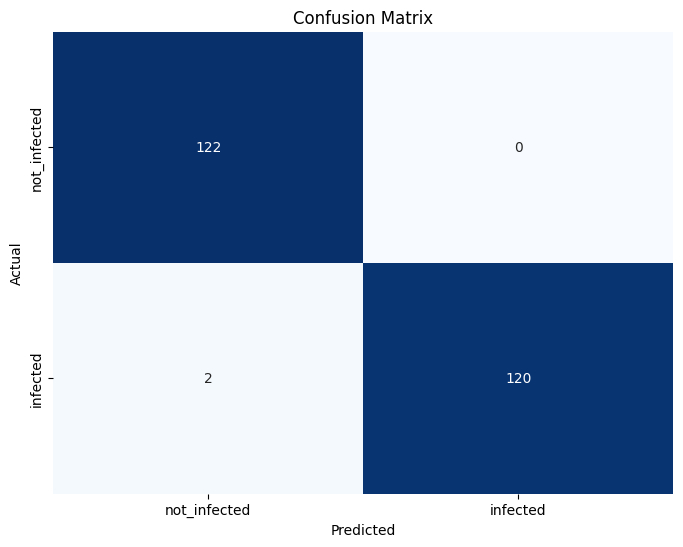

In [79]:
# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


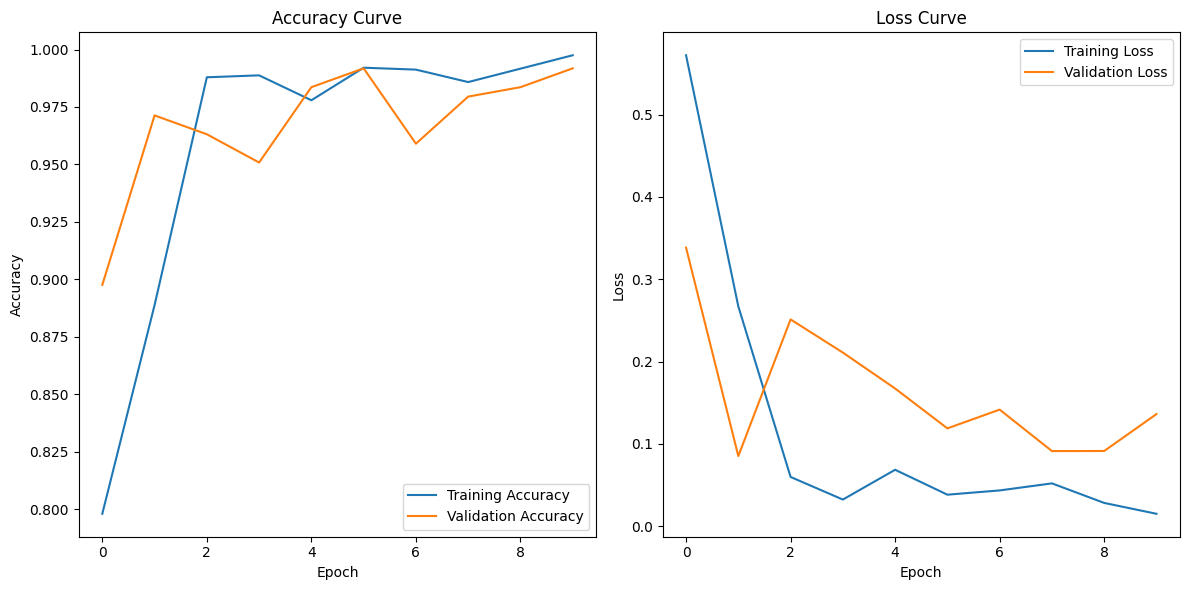

In [72]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['test_acc'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['test_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [77]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
predictions = []
true_labels = []

# Iterate over the test dataset
for inputs, labels in test_loader:
    inputs = inputs.to(device)  # Move inputs to the device (e.g., GPU)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs)

    # Convert logits to probabilities using softmax
    probabilities = torch.softmax(outputs, dim=1)

    # Get the predicted class (index with maximum probability)
    _, predicted = torch.max(probabilities, 1)

    # Append predictions and true labels to the lists
    predictions.extend(predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
y_pred = np.array(predictions)
y_true = np.array(true_labels)


In [78]:

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Generate evaluation table
evaluation_table = pd.DataFrame({
    'Metrics': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy_score(y_true, y_pred),
              precision_score(y_true, y_pred),
              recall_score(y_true, y_pred),
              f1_score(y_true, y_pred)]
})
print(evaluation_table)


     Metrics     Value
0   Accuracy  0.991803
1  Precision  1.000000
2     Recall  0.983607
3   F1 Score  0.991736
